In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from PIL import Image

ims = list()
masks = list()
counts = np.empty((50, 256, 256))
dir = '/content/gdrive/My Drive/ColabData/dataset_final/'
for i in range(50):
  # read in and store patches
  try:
    im = Image.open(dir + 'patch' + str(i+1) + '.tiff')
  except FileNotFoundError:
    im = Image.open(dir + 'patch' + str(i+1) + '.tif')
  im = np.array(im.convert('L'))
  ims.append(im)
  # read in and store masks
  try:
    mask = Image.open(dir + 'mask' + str(i+1) + '.tiff')
  except FileNotFoundError:
    mask = Image.open(dir + 'mask' + str(i+1) + '.tif')
  mask = np.array(mask.convert('L')) 
  # read in and store counts
  try:
    count = Image.open(dir + 'count' + str(i+1) + '.tiff')
  except FileNotFoundError:
    count = Image.open(dir + 'count' + str(i+1) + '.tif')
  count = np.array(count.convert('L'))
  print(count.shape)
  # make sure the cell is marked as 1
  if np.max(mask) == 255 and np.min(mask) == 1:
    mask = (mask - 1) / 254 * 255
  if np.max(mask) != 255:
    mask = mask / np.max(mask) * 255
  if np.count_nonzero(mask==0) < np.count_nonzero(mask):
    mask = 255 - mask
  masks.append(mask)
  
  if np.max(count) == 255 and np.min(count) == 1:
    count = (count - 1) / 254 * 255
  if np.max(count) != 255:
    count = count / np.max(count) * 255
  if np.count_nonzero(count==0) < np.count_nonzero(count):
    count = 255 - count
  counts[i, :, :] = count

images = np.array(ims).reshape((-1, 256, 256, 1)) / 255
masks = np.array(masks).reshape((-1, 256, 256, 1)) / 255
counts = np.array(counts).reshape((-1, 256, 256, 1)) / 255
print(images.shape)
print(masks.shape)
print(counts.shape)
#plt.imshow(masks[1, :, :, 0])
#plt.imshow(ims[1, :, :, 0])

In [5]:
import keras.backend.tensorflow_backend as K
import tensorflow as tf
from sklearn.model_selection import KFold

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Lambda, concatenate, Input, UpSampling2D, BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.core import Dropout
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

!pip install imutils
import imutils
import cv2

Using TensorFlow backend.


In [0]:
from keras.losses import binary_crossentropy
from keras.activations import sigmoid

def lossFunc(true, pred):
  
  weight = 3
  '''
  pred = tf.sign((tf.sign(pred - 0.5) + 1) / 2)
  sz = K.cast(tf.size(true), 'float32')
  true_1 = K.sum(true) / sz
  true_0 = K.sum(1 - true) / sz
  pred_1 = K.sum(pred) / sz + K.epsilon()
  pred_0 = K.sum(1 - pred) / sz + K.epsilon()
  logloss = true_1 * K.log(1/pred_1) * weight + true_0 * K.log(1/pred_0)
  return logloss
  '''
  true = K.clip(true, K.epsilon(), 1)
  pred = sigmoid(pred)
  
  logloss = -(true * K.log(pred) * weight + (1 - true) * K.log(1 - pred))
  return K.mean(logloss, axis=-1)

  
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Classification:
1.   Last layer uses 'sigmoid' activation function
2.   Loss function is 'binary_crossentropy'
3.   Cropping generator needs to binarize the mask
4.   Calculate binary difference on test set

Regression:
1.   Last layer uses 'linear' activation function
2.   Loss function is 'mean_squared_error'
3.   Cropping generator doesn't need to binarize the mask
4.   Calculate MSE on test set



In [0]:
def down(filters, input_):
  down_ = Conv2D(filters, (3, 3), padding='same')(input_)
  down_ = BatchNormalization(epsilon=1e-4)(down_)
  down_ = Activation('relu')(down_)
  down_ = Conv2D(filters, (3, 3), padding='same')(down_)
  down_ = BatchNormalization(epsilon=1e-4)(down_)
  down_res = Activation('relu')(down_)
  down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_res)
  return down_pool, down_res


def up(filters, input_, down_):
  #up_ = UpSampling2D((2, 2))(input_)
  
  up_ = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input_)
  up_ = concatenate([down_, up_], axis=-1)
  
  up_ = Conv2D(filters, (3, 3), padding='same')(up_)
  up_ = BatchNormalization(epsilon=1e-4)(up_)
  up_ = Activation('relu')(up_)
  up_ = Conv2D(filters, (3, 3), padding='same')(up_)
  up_ = BatchNormalization(epsilon=1e-4)(up_)
  up_ = Activation('relu')(up_)
  return up_


def create_model():
  inputs = Input(shape=(None, None, 1))
  # 256, 256, 1
  down0, down0_res = down(32, inputs)
  # 128, 128, 64
  down1, down1_res = down(64, down0)
  # 64, 64, 128
  down2, down2_res = down(128, down1)
  # 32, 32, 256
  down3, down3_res = down(256, down2)
  # 16, 16, 512
  down4, down4_res = down(512, down3)
  # 8, 8, 1024

  center = Conv2D(512, (3, 3), padding='same')(down4)
  center = BatchNormalization(epsilon=1e-4)(center)
  center = Activation('relu')(center)
  center = Conv2D(512, (3, 3), padding='same')(center)
  center = BatchNormalization(epsilon=1e-4)(center)
  center = Activation('relu')(center)

  up4 = up(512, center, down4_res)
  up3 = up(256, up4, down3_res)
  up2 = up(128, up3, down2_res)
  up1 = up(64, up2, down1_res)
  up0 = up(32, up1, down0_res)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(up0)

  model = Model(inputs=inputs, outputs=outputs)
  adam_op = adam(lr=1e-4)#, epsilon=0.1)
  model.compile(optimizer=adam_op, loss=lossFunc, metrics=['accuracy'])

  return model
  

In [0]:
def random_crop(img, mask, random_crop_size):
    # Note: image_data_format is 'channel_last'
    #assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return (img[y:(y+dy), x:(x+dx), :], mask[y:(y+dy), x:(x+dx), :])
  

def train_generator(ids, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(ids, size=batch_size, replace=False)
        for c, i in enumerate(batch_ids):
            x = images[i, :, :, :]
            y = masks[i, :, :, :]
            x, y = randomShiftScaleRotate(x, y)
            #x, y = random_crop(x, y, (128, 128))
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        '''
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(X[0,:,:,0])
        ax1.grid(False)
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(Y[0,:,:,0])
        ax2.grid(False)
        '''
        yield X, Y
        
        
def valid_generator(ids, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(ids, size=batch_size, replace=False)
        for c, i in enumerate(batch_ids):
            x = images[i, :, :, :]
            y = masks[i, :, :, :]
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

In [0]:
# define generator which takes batch (image) data from ‘ImageDataGenerator’ and does random cropping on the batch
def random_crop(img, mask, random_crop_size):
    # Note: image_data_format is 'channel_last'
    #assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return (img[y:(y+dy), x:(x+dx), :], mask[y:(y+dy), x:(x+dx), :])
  
  
def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops_x = np.zeros((batch_x.shape[0], crop_length, crop_length, batch_x.shape[3]))
        batch_crops_y = np.zeros((batch_y.shape[0], crop_length, crop_length, batch_y.shape[3]))
        for i in range(batch_x.shape[0]):
            batch_crops_x[i], batch_crops_y[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
   
            #current_min = np.min(batch_crops_y[i])
            #current_max = np.max(batch_crops_y[i])
            #medium = (current_min + current_max) / 2
            #batch_crops_y[i] = np.where(batch_crops_y[i] > medium, 1, 0)
            
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(batch_crops_x[0,:,:,0])
        ax1.grid(False)
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(batch_crops_y[0,:,:,0])
        ax2.grid(False)
                  
        yield (batch_crops_x, batch_crops_y)


In [0]:
def get_callbacks(name_weights):
  mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
  earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', min_delta = 0.0001)
  
  return [earlyStopping]

In [128]:
im = Image.open('/content/gdrive/My Drive/ColabData/He2_1_2_3.tiff')
im = np.array(im.convert('L'))
im = np.array(im).reshape((7001, 6001, 1)) / 255
im = im[44:6956, 184:5816]
ims = list()
for i in range(27):
  for j in range(22):
    ims.append(im[i*256:(i+1)*256, j*256:(j+1)*256, :])
ims = np.array(ims)
print(ims.shape)

(594, 256, 256, 1)


In [10]:
# create two instances with the same arguments
datagen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True)
train_image_datagen = ImageDataGenerator(**datagen_args)
train_mask_datagen = ImageDataGenerator(**datagen_args)

valid_image_datagen = ImageDataGenerator()
valid_mask_datagen = ImageDataGenerator()

train_batch_sz = 8
valid_batch_sz = 1
scores = []
# K-fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=666)
for train, test in kf.split(images):
  x_train, x_test, y_train, y_test = images[train,:,:,:], images[test,:,:,:], masks[train,:,:,:], masks[test,:,:,:]
  y_count = counts[test,:,:,:]
  #train_gen = train_generator(train, batch_sz)
  #valid_gen = valid_generator(test, 1)
  valid_steps = int(len(test) / valid_batch_sz)
  
  # Provide the same seed and keyword arguments to the fit and flow methods
  seed = 1
  train_image_datagen.fit(x_train, augment=True, seed=seed)
  train_mask_datagen.fit(y_train, augment=True, seed=seed)
  valid_image_datagen.fit(x_test, augment=False)
  valid_mask_datagen.fit(y_test, augment=False)
  # random cropping 
  train_batches = zip(train_image_datagen.flow(x_train, batch_size=train_batch_sz, seed=seed), 
                     train_mask_datagen.flow(y_train, batch_size=train_batch_sz, seed=seed))
  #train_crops = crop_generator(train_batches, 128)
  valid_batches = zip(valid_image_datagen.flow(x_test, batch_size=valid_batch_sz, seed=seed), 
                     valid_mask_datagen.flow(y_test, batch_size=valid_batch_sz, seed=seed))
  #valid_crops = crop_generator(valid_batches, 128)
  
  # train the model
  model = create_model()
  #print(model.summary())
  #model.fit(x_train, y_train, batch_size=8, epochs=5, verbose=1, 
  #          callbacks=get_callbacks('MIA_FCN_1.h5'), validation_data=(x_test, y_test))
  model.fit_generator(train_batches, steps_per_epoch=20, epochs=20, 
                      callbacks=get_callbacks('MIA_FCN_1.h5'), shuffle=False, verbose=1,
                      validation_data=valid_batches, validation_steps=valid_steps)
  y_pred = model.predict(x_test)
  for i in range(test):
    pred = np.where(y_pred[i,:,:,0] > 0.5, 1, 0)
    # find contours in the edge map
    cnts = cv2.findContours(pred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    print(np.sum(y_count[i])-1)
    print(len(cnts))
    print('='*10)
  #score = np.mean(np.square(y_test - y_pred))
  score = K.mean(K.equal(K.cast(y_test, 'float32'), K.round(y_pred)))
  #score = dice_coef(y_test, y_pred)
  score = K.eval(score)
  print(score)
  scores.append(score)
  im_preds = list()
  for i in range(27):
    im_preds.extend(model.predict(ims[i*22:(i+1)*22]))
  break

print(np.mean(scores))
print(np.std(scores))


Epoch 1/20
20/20 [==============================] - 22s 1s/step - loss: 1.0156 - acc: 0.4903 - val_loss: 0.9755 - val_acc: 0.6583
Epoch 2/20
20/20 [==============================] - 10s 505ms/step - loss: 0.9440 - acc: 0.7580 - val_loss: 0.9022 - val_acc: 0.8082
Epoch 3/20
20/20 [==============================] - 10s 507ms/step - loss: 0.9092 - acc: 0.8134 - val_loss: 0.8756 - val_acc: 0.8716
Epoch 4/20
20/20 [==============================] - 10s 507ms/step - loss: 0.8889 - acc: 0.8407 - val_loss: 0.8634 - val_acc: 0.9025
Epoch 5/20
20/20 [==============================] - 10s 509ms/step - loss: 0.8763 - acc: 0.8582 - val_loss: 0.8279 - val_acc: 0.9235
Epoch 6/20
20/20 [==============================] - 10s 508ms/step - loss: 0.8662 - acc: 0.8737 - val_loss: 0.8441 - val_acc: 0.9245
Epoch 7/20
20/20 [==============================] - 10s 510ms/step - loss: 0.8598 - acc: 0.8830 - val_loss: 0.8441 - val_acc: 0.9298
Epoch 00007: early stopping


TypeError: ignored

(-0.5, 255.5, 255.5, -0.5)

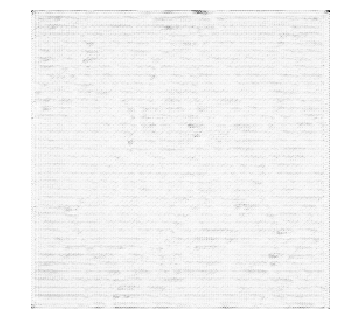

In [152]:
im_res = np.zeros((6912, 5632))

for i in range(27):
  for j in range(22):
    tmp = im_preds[i*22+j]
    im_res[i*256:(i+1)*256, j*256:(j+1)*256] = tmp[:, :, 0]
    
f = plt.figure()
plt.imshow(im_preds[80][:, :, 0])
plt.grid(False)
plt.axis('off')
#f.savefig('test.png')
#files.download( "test.png" ) 

In [119]:
print(np.asarray(im_preds).shape)

(28, 6, 480, 480, 1)


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'\ncurrent_min = np.min(mask)\ncurrent_max = np.max(mask)\nmedium = (current_min + current_max) / 2\ntmp = np.where(mask > medium, 1, 0)\nax4 = fig.add_subplot(1,4,4)\nax4.imshow(np.where(mask>0.6, 1, 0))\nax4.grid(False)\n'

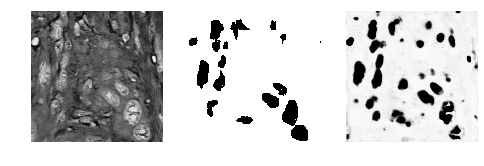

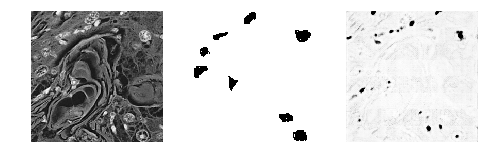

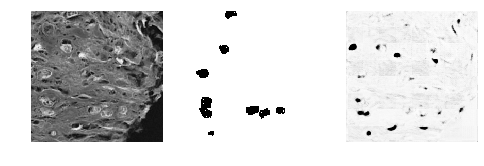

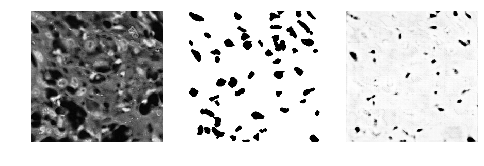

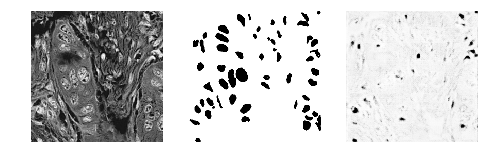

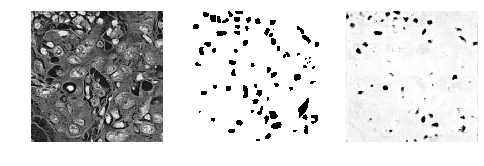

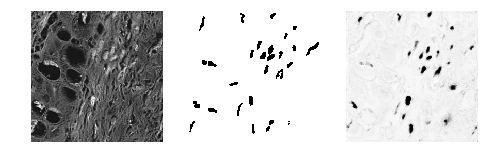

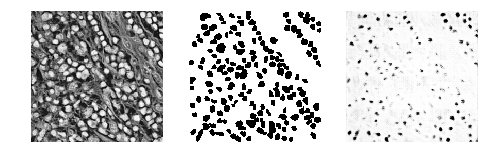

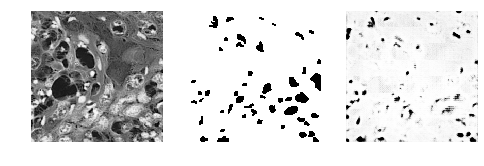

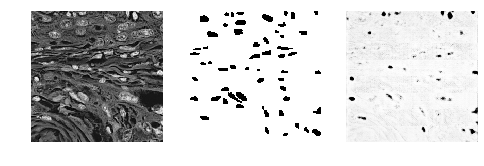

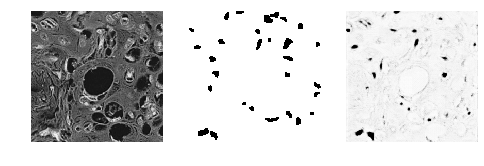

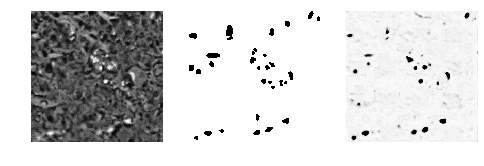

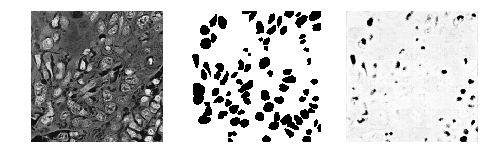

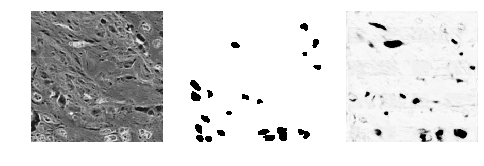

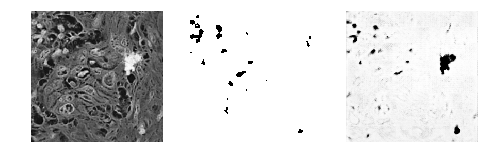

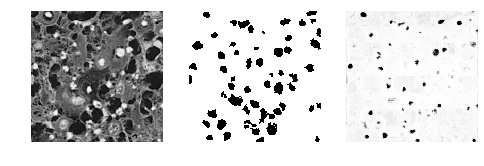

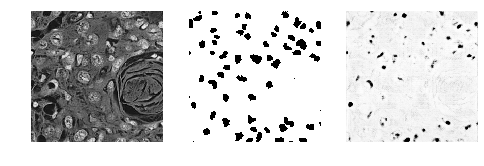

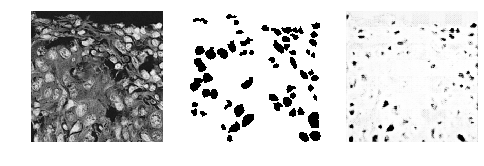

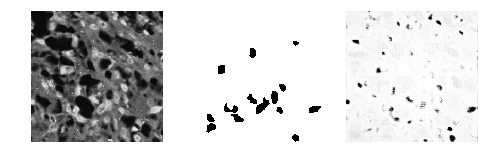

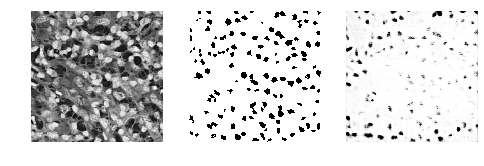

In [148]:
#import matplotlib.gridspec as gridspec

n = len(test)

fig = plt.figure()
#gs = gridspec.GridSpec(n, 3)
#gs.update(wspace=0.025, hspace=0.05)
for i in range(n):
  fig = plt.figure()
  ax1 = fig.add_subplot(1,3,1)
  ax1.imshow(x_test[i,:,:,0])
  ax1.grid(False)
  ax1.axis('off')
  ax2 = fig.add_subplot(1,3,2)
  ax2.imshow(y_test[i,:,:,0])
  ax2.grid(False)
  ax2.axis('off')
  ax3 = fig.add_subplot(1,3,3)
  ax3.imshow(y_pred[i,:,:,0])
  ax3.grid(False)
  ax3.axis('off')

'''
current_min = np.min(mask)
current_max = np.max(mask)
medium = (current_min + current_max) / 2
tmp = np.where(mask > medium, 1, 0)
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(np.where(mask>0.6, 1, 0))
ax4.grid(False)
'''

In [0]:
plt.hist(y_pred.flatten())

In [0]:
model.save_weights('MIA_keras_1.h5') 